# Rated DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
import numpy as np
rewards = [each[3] for each in batch]
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.0


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [7]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [9]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=rates)) # 0-1
    dlossA /= 2
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [10]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [12]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [20]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [22]:
goal = 500
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/goal
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        num_step = 0 # reset

In [23]:
idx = np.random.choice(np.arange(memory_size// batch_size))
batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
rates = np.array([each[5] for each in batch])
batch = batch[rates >= (np.max(rates)*0.9)]
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
rates = np.array([each[5] for each in batch])

In [24]:
batch.shape, \
states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape

((190, 6), (190, 4), (190,), (190, 4), (190,), (190,), (190,))

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dlossA_list, dlossQ_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        total_reward = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
            
            # Training using a max rated batch
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])
                if (np.max(rates)*0.9) > 0: # non-rated data -1
                    break
            batch = batch[rates >= (np.max(rates)*0.9)]
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rates = np.array([each[5] for each in batch])            
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA, model.d_optQ],
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dlossA_list.append([ep, np.mean(dlossA_batch)])
        dlossQ_list.append([ep, np.mean(dlossQ_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= goal:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:23.0000 R:23.0000 rate:0.0460 gloss:0.7312 dlossA:0.7009 dlossQ:0.9339 exploreP:0.9977
Episode:1 meanR:16.5000 R:10.0000 rate:0.0200 gloss:0.7280 dlossA:0.7003 dlossQ:0.9225 exploreP:0.9967
Episode:2 meanR:14.6667 R:11.0000 rate:0.0220 gloss:0.7206 dlossA:0.7004 dlossQ:0.9124 exploreP:0.9957
Episode:3 meanR:18.7500 R:31.0000 rate:0.0620 gloss:0.7264 dlossA:0.7010 dlossQ:0.9184 exploreP:0.9926
Episode:4 meanR:17.6000 R:13.0000 rate:0.0260 gloss:0.7180 dlossA:0.7011 dlossQ:0.9362 exploreP:0.9913
Episode:5 meanR:17.0000 R:14.0000 rate:0.0280 gloss:0.7142 dlossA:0.7042 dlossQ:0.9335 exploreP:0.9900
Episode:6 meanR:16.2857 R:12.0000 rate:0.0240 gloss:0.7179 dlossA:0.7029 dlossQ:0.9371 exploreP:0.9888
Episode:7 meanR:17.0000 R:22.0000 rate:0.0440 gloss:0.7089 dlossA:0.7020 dlossQ:0.9222 exploreP:0.9866
Episode:8 meanR:17.6667 R:23.0000 rate:0.0460 gloss:0.7120 dlossA:0.7038 dlossQ:0.9303 exploreP:0.9844
Episode:9 meanR:17.7000 R:18.0000 rate:0.0360 gloss:0.7109 dlossA:0.7057 

Episode:79 meanR:24.3750 R:34.0000 rate:0.0680 gloss:0.6712 dlossA:0.7064 dlossQ:0.9536 exploreP:0.8246
Episode:80 meanR:24.2469 R:14.0000 rate:0.0280 gloss:0.6734 dlossA:0.7038 dlossQ:0.9752 exploreP:0.8235
Episode:81 meanR:24.2927 R:28.0000 rate:0.0560 gloss:0.6807 dlossA:0.7069 dlossQ:0.9572 exploreP:0.8212
Episode:82 meanR:24.1325 R:11.0000 rate:0.0220 gloss:0.6901 dlossA:0.7052 dlossQ:0.9913 exploreP:0.8203
Episode:83 meanR:24.0119 R:14.0000 rate:0.0280 gloss:0.6888 dlossA:0.7089 dlossQ:0.9645 exploreP:0.8192
Episode:84 meanR:24.5059 R:66.0000 rate:0.1320 gloss:0.6734 dlossA:0.7057 dlossQ:0.9605 exploreP:0.8138
Episode:85 meanR:24.4419 R:19.0000 rate:0.0380 gloss:0.6716 dlossA:0.7064 dlossQ:0.9583 exploreP:0.8123
Episode:86 meanR:24.3678 R:18.0000 rate:0.0360 gloss:0.6740 dlossA:0.7073 dlossQ:0.9541 exploreP:0.8109
Episode:87 meanR:24.5341 R:39.0000 rate:0.0780 gloss:0.6770 dlossA:0.7070 dlossQ:0.9622 exploreP:0.8078
Episode:88 meanR:24.3933 R:12.0000 rate:0.0240 gloss:0.6680 dlos

Episode:158 meanR:47.8200 R:106.0000 rate:0.2120 gloss:0.6891 dlossA:0.7126 dlossQ:0.9715 exploreP:0.5441
Episode:159 meanR:48.5800 R:84.0000 rate:0.1680 gloss:0.6882 dlossA:0.7112 dlossQ:0.9797 exploreP:0.5396
Episode:160 meanR:49.3500 R:89.0000 rate:0.1780 gloss:0.6839 dlossA:0.7099 dlossQ:0.9727 exploreP:0.5350
Episode:161 meanR:49.7500 R:76.0000 rate:0.1520 gloss:0.6797 dlossA:0.7118 dlossQ:0.9669 exploreP:0.5310
Episode:162 meanR:49.6600 R:20.0000 rate:0.0400 gloss:0.7007 dlossA:0.7117 dlossQ:0.9911 exploreP:0.5299
Episode:163 meanR:50.5200 R:98.0000 rate:0.1960 gloss:0.6816 dlossA:0.7117 dlossQ:0.9696 exploreP:0.5249
Episode:164 meanR:50.3900 R:28.0000 rate:0.0560 gloss:0.6810 dlossA:0.7105 dlossQ:0.9715 exploreP:0.5234
Episode:165 meanR:51.0800 R:115.0000 rate:0.2300 gloss:0.6891 dlossA:0.7120 dlossQ:0.9733 exploreP:0.5176
Episode:166 meanR:51.8600 R:89.0000 rate:0.1780 gloss:0.6850 dlossA:0.7138 dlossQ:0.9649 exploreP:0.5131
Episode:167 meanR:52.8500 R:131.0000 rate:0.2620 glos

Episode:236 meanR:114.5400 R:256.0000 rate:0.5120 gloss:0.7362 dlossA:0.7472 dlossQ:0.9527 exploreP:0.2100
Episode:237 meanR:115.6200 R:141.0000 rate:0.2820 gloss:0.7337 dlossA:0.7497 dlossQ:0.9512 exploreP:0.2072
Episode:238 meanR:116.7500 R:171.0000 rate:0.3420 gloss:0.7499 dlossA:0.7561 dlossQ:0.9437 exploreP:0.2039
Episode:239 meanR:117.0900 R:118.0000 rate:0.2360 gloss:0.7479 dlossA:0.7580 dlossQ:0.9436 exploreP:0.2016
Episode:240 meanR:117.4200 R:121.0000 rate:0.2420 gloss:0.7436 dlossA:0.7526 dlossQ:0.9452 exploreP:0.1993
Episode:241 meanR:118.6700 R:307.0000 rate:0.6140 gloss:0.7479 dlossA:0.7565 dlossQ:0.9394 exploreP:0.1936
Episode:242 meanR:119.4900 R:215.0000 rate:0.4300 gloss:0.7522 dlossA:0.7581 dlossQ:0.9436 exploreP:0.1896
Episode:243 meanR:120.7200 R:186.0000 rate:0.3720 gloss:0.7557 dlossA:0.7630 dlossQ:0.9379 exploreP:0.1863
Episode:244 meanR:121.6600 R:126.0000 rate:0.2520 gloss:0.7660 dlossA:0.7644 dlossQ:0.9421 exploreP:0.1841
Episode:245 meanR:122.7500 R:212.0000

Episode:313 meanR:256.9700 R:210.0000 rate:0.4200 gloss:1.8315 dlossA:1.5261 dlossQ:0.8362 exploreP:0.0320
Episode:314 meanR:257.0000 R:181.0000 rate:0.3620 gloss:1.8665 dlossA:1.5751 dlossQ:0.8436 exploreP:0.0316
Episode:315 meanR:260.7100 R:500.0000 rate:1.0000 gloss:1.8670 dlossA:1.5204 dlossQ:0.8348 exploreP:0.0306
Episode:316 meanR:262.5800 R:364.0000 rate:0.7280 gloss:1.9278 dlossA:1.5429 dlossQ:0.8319 exploreP:0.0298
Episode:317 meanR:260.9200 R:150.0000 rate:0.3000 gloss:1.9636 dlossA:1.5960 dlossQ:0.8310 exploreP:0.0295
Episode:318 meanR:264.2800 R:500.0000 rate:1.0000 gloss:2.0041 dlossA:1.6867 dlossQ:0.8356 exploreP:0.0286
Episode:319 meanR:268.3900 R:500.0000 rate:1.0000 gloss:2.0434 dlossA:1.6199 dlossQ:0.8314 exploreP:0.0277
Episode:320 meanR:272.0500 R:500.0000 rate:1.0000 gloss:2.1137 dlossA:1.7431 dlossQ:0.8218 exploreP:0.0268
Episode:321 meanR:275.0200 R:500.0000 rate:1.0000 gloss:2.1907 dlossA:1.7794 dlossQ:0.8387 exploreP:0.0260
Episode:322 meanR:279.3200 R:500.0000

Episode:390 meanR:388.9500 R:500.0000 rate:1.0000 gloss:8.4236 dlossA:5.9231 dlossQ:2.4095 exploreP:0.0110
Episode:391 meanR:389.2000 R:500.0000 rate:1.0000 gloss:8.7637 dlossA:6.0484 dlossQ:2.6191 exploreP:0.0110
Episode:392 meanR:392.6700 R:500.0000 rate:1.0000 gloss:9.2068 dlossA:6.5388 dlossQ:2.6325 exploreP:0.0109
Episode:393 meanR:390.3100 R:264.0000 rate:0.5280 gloss:9.4086 dlossA:6.4933 dlossQ:2.7917 exploreP:0.0109
Episode:394 meanR:391.1700 R:290.0000 rate:0.5800 gloss:9.6113 dlossA:6.9908 dlossQ:3.9264 exploreP:0.0109
Episode:395 meanR:393.8100 R:500.0000 rate:1.0000 gloss:9.5794 dlossA:6.8828 dlossQ:3.0777 exploreP:0.0108
Episode:396 meanR:395.1700 R:273.0000 rate:0.5460 gloss:9.6829 dlossA:6.6487 dlossQ:3.2053 exploreP:0.0108
Episode:397 meanR:395.1700 R:500.0000 rate:1.0000 gloss:10.2161 dlossA:7.2026 dlossQ:3.2662 exploreP:0.0108
Episode:398 meanR:392.6100 R:244.0000 rate:0.4880 gloss:10.4846 dlossA:8.1352 dlossQ:4.3114 exploreP:0.0107
Episode:399 meanR:395.7500 R:500.00

Episode:466 meanR:423.8700 R:368.0000 rate:0.7360 gloss:18.5177 dlossA:5.6874 dlossQ:8.0170 exploreP:0.0100
Episode:467 meanR:426.6100 R:500.0000 rate:1.0000 gloss:18.9184 dlossA:6.8769 dlossQ:9.6847 exploreP:0.0100
Episode:468 meanR:428.9900 R:500.0000 rate:1.0000 gloss:18.8711 dlossA:5.6069 dlossQ:8.5960 exploreP:0.0100
Episode:469 meanR:427.8300 R:384.0000 rate:0.7680 gloss:18.8266 dlossA:5.3497 dlossQ:11.8100 exploreP:0.0100
Episode:470 meanR:431.1100 R:500.0000 rate:1.0000 gloss:19.0994 dlossA:6.1732 dlossQ:7.9480 exploreP:0.0100
Episode:471 meanR:429.4500 R:334.0000 rate:0.6680 gloss:19.1615 dlossA:5.6892 dlossQ:7.9406 exploreP:0.0100
Episode:472 meanR:426.4100 R:196.0000 rate:0.3920 gloss:19.6430 dlossA:6.3687 dlossQ:8.8485 exploreP:0.0100
Episode:473 meanR:426.4100 R:500.0000 rate:1.0000 gloss:19.6851 dlossA:5.0327 dlossQ:9.7191 exploreP:0.0100
Episode:474 meanR:429.3100 R:500.0000 rate:1.0000 gloss:20.6921 dlossA:6.5710 dlossQ:9.8215 exploreP:0.0100
Episode:475 meanR:430.1100 

Episode:542 meanR:443.4200 R:500.0000 rate:1.0000 gloss:15.3187 dlossA:0.0607 dlossQ:13.5821 exploreP:0.0100
Episode:543 meanR:443.4200 R:500.0000 rate:1.0000 gloss:15.5187 dlossA:0.0000 dlossQ:13.4531 exploreP:0.0100
Episode:544 meanR:443.4200 R:500.0000 rate:1.0000 gloss:15.8471 dlossA:0.0302 dlossQ:15.9763 exploreP:0.0100
Episode:545 meanR:443.4200 R:500.0000 rate:1.0000 gloss:15.4066 dlossA:0.0000 dlossQ:12.9766 exploreP:0.0100
Episode:546 meanR:444.7200 R:500.0000 rate:1.0000 gloss:15.1376 dlossA:0.0599 dlossQ:13.6537 exploreP:0.0100
Episode:547 meanR:444.7200 R:500.0000 rate:1.0000 gloss:14.7108 dlossA:0.0000 dlossQ:12.8843 exploreP:0.0100
Episode:548 meanR:444.7200 R:500.0000 rate:1.0000 gloss:14.8580 dlossA:0.0000 dlossQ:13.3569 exploreP:0.0100
Episode:549 meanR:442.4200 R:270.0000 rate:0.5400 gloss:14.7644 dlossA:0.0000 dlossQ:13.0036 exploreP:0.0100
Episode:550 meanR:445.8600 R:500.0000 rate:1.0000 gloss:15.0523 dlossA:0.0607 dlossQ:13.3052 exploreP:0.0100
Episode:551 meanR:4

Episode:618 meanR:481.8200 R:500.0000 rate:1.0000 gloss:9.4095 dlossA:0.0409 dlossQ:11.4981 exploreP:0.0100
Episode:619 meanR:480.0500 R:323.0000 rate:0.6460 gloss:9.3488 dlossA:0.1309 dlossQ:10.6864 exploreP:0.0100
Episode:620 meanR:480.0500 R:500.0000 rate:1.0000 gloss:9.1547 dlossA:0.0209 dlossQ:11.0831 exploreP:0.0100
Episode:621 meanR:480.0500 R:500.0000 rate:1.0000 gloss:9.1986 dlossA:0.0593 dlossQ:11.2243 exploreP:0.0100
Episode:622 meanR:480.0500 R:500.0000 rate:1.0000 gloss:9.3195 dlossA:0.0196 dlossQ:11.5364 exploreP:0.0100
Episode:623 meanR:480.0500 R:500.0000 rate:1.0000 gloss:9.5764 dlossA:0.0429 dlossQ:12.3991 exploreP:0.0100
Episode:624 meanR:481.6400 R:500.0000 rate:1.0000 gloss:9.6657 dlossA:0.0476 dlossQ:12.6020 exploreP:0.0100
Episode:625 meanR:481.6400 R:500.0000 rate:1.0000 gloss:9.5245 dlossA:0.0208 dlossQ:13.3746 exploreP:0.0100
Episode:626 meanR:485.1200 R:500.0000 rate:1.0000 gloss:9.5832 dlossA:0.0307 dlossQ:13.2861 exploreP:0.0100
Episode:627 meanR:485.1200 R

Episode:694 meanR:484.9700 R:500.0000 rate:1.0000 gloss:7.1242 dlossA:0.0616 dlossQ:13.0871 exploreP:0.0100
Episode:695 meanR:484.9700 R:500.0000 rate:1.0000 gloss:7.2167 dlossA:0.0378 dlossQ:12.9205 exploreP:0.0100
Episode:696 meanR:484.0300 R:406.0000 rate:0.8120 gloss:7.1089 dlossA:0.0802 dlossQ:12.8187 exploreP:0.0100
Episode:697 meanR:484.0300 R:500.0000 rate:1.0000 gloss:7.0720 dlossA:0.0454 dlossQ:13.0958 exploreP:0.0100
Episode:698 meanR:484.0300 R:500.0000 rate:1.0000 gloss:7.0160 dlossA:0.0676 dlossQ:12.8233 exploreP:0.0100
Episode:699 meanR:484.0300 R:500.0000 rate:1.0000 gloss:7.0646 dlossA:0.0830 dlossQ:12.9212 exploreP:0.0100
Episode:700 meanR:484.0300 R:500.0000 rate:1.0000 gloss:7.0229 dlossA:0.0935 dlossQ:12.7789 exploreP:0.0100
Episode:701 meanR:485.4000 R:500.0000 rate:1.0000 gloss:6.8858 dlossA:0.0381 dlossQ:12.8568 exploreP:0.0100
Episode:702 meanR:485.4000 R:500.0000 rate:1.0000 gloss:6.9852 dlossA:0.0734 dlossQ:12.9014 exploreP:0.0100
Episode:703 meanR:485.0500 R

Episode:770 meanR:491.2800 R:500.0000 rate:1.0000 gloss:5.8687 dlossA:0.1091 dlossQ:12.5506 exploreP:0.0100
Episode:771 meanR:491.2800 R:500.0000 rate:1.0000 gloss:5.9608 dlossA:0.1191 dlossQ:12.4350 exploreP:0.0100
Episode:772 meanR:491.2800 R:500.0000 rate:1.0000 gloss:5.8582 dlossA:0.1418 dlossQ:12.2231 exploreP:0.0100
Episode:773 meanR:490.6100 R:433.0000 rate:0.8660 gloss:5.6900 dlossA:0.1150 dlossQ:12.8690 exploreP:0.0100
Episode:774 meanR:490.7000 R:500.0000 rate:1.0000 gloss:5.7681 dlossA:0.1215 dlossQ:13.0544 exploreP:0.0100
Episode:775 meanR:490.7000 R:500.0000 rate:1.0000 gloss:5.6646 dlossA:0.1241 dlossQ:12.2515 exploreP:0.0100
Episode:776 meanR:491.6000 R:500.0000 rate:1.0000 gloss:5.6495 dlossA:0.1362 dlossQ:12.3645 exploreP:0.0100
Episode:777 meanR:491.6000 R:500.0000 rate:1.0000 gloss:5.6780 dlossA:0.0909 dlossQ:12.6802 exploreP:0.0100
Episode:778 meanR:491.6000 R:500.0000 rate:1.0000 gloss:5.7613 dlossA:0.0982 dlossQ:12.5305 exploreP:0.0100
Episode:779 meanR:491.6000 R

Episode:846 meanR:492.8800 R:500.0000 rate:1.0000 gloss:5.4966 dlossA:0.1461 dlossQ:12.2961 exploreP:0.0100
Episode:847 meanR:492.8800 R:500.0000 rate:1.0000 gloss:5.5530 dlossA:0.1169 dlossQ:12.6447 exploreP:0.0100
Episode:848 meanR:492.8800 R:500.0000 rate:1.0000 gloss:5.5827 dlossA:0.1249 dlossQ:12.6304 exploreP:0.0100
Episode:849 meanR:493.9200 R:500.0000 rate:1.0000 gloss:5.5228 dlossA:0.1236 dlossQ:12.6542 exploreP:0.0100
Episode:850 meanR:493.9200 R:500.0000 rate:1.0000 gloss:5.4954 dlossA:0.1678 dlossQ:12.3601 exploreP:0.0100
Episode:851 meanR:493.9200 R:500.0000 rate:1.0000 gloss:5.5388 dlossA:0.1532 dlossQ:12.3548 exploreP:0.0100
Episode:852 meanR:493.9200 R:500.0000 rate:1.0000 gloss:5.4731 dlossA:0.1279 dlossQ:12.6649 exploreP:0.0100
Episode:853 meanR:493.9200 R:500.0000 rate:1.0000 gloss:5.5576 dlossA:0.1174 dlossQ:12.6737 exploreP:0.0100
Episode:854 meanR:493.9200 R:500.0000 rate:1.0000 gloss:5.4674 dlossA:0.1244 dlossQ:12.5366 exploreP:0.0100
Episode:855 meanR:493.9200 R

Episode:922 meanR:488.6100 R:500.0000 rate:1.0000 gloss:5.3833 dlossA:0.1404 dlossQ:11.6592 exploreP:0.0100
Episode:923 meanR:488.6100 R:500.0000 rate:1.0000 gloss:5.4865 dlossA:0.1136 dlossQ:11.6592 exploreP:0.0100
Episode:924 meanR:488.6100 R:500.0000 rate:1.0000 gloss:5.3486 dlossA:0.0908 dlossQ:11.7536 exploreP:0.0100
Episode:925 meanR:489.4900 R:500.0000 rate:1.0000 gloss:5.3275 dlossA:0.1261 dlossQ:11.5969 exploreP:0.0100
Episode:926 meanR:489.4900 R:500.0000 rate:1.0000 gloss:5.5266 dlossA:0.0999 dlossQ:12.2238 exploreP:0.0100
Episode:927 meanR:489.4900 R:500.0000 rate:1.0000 gloss:5.3557 dlossA:0.1074 dlossQ:11.7008 exploreP:0.0100
Episode:928 meanR:489.4900 R:500.0000 rate:1.0000 gloss:5.4119 dlossA:0.1154 dlossQ:11.7599 exploreP:0.0100
Episode:929 meanR:489.0800 R:459.0000 rate:0.9180 gloss:5.3320 dlossA:0.0859 dlossQ:11.5668 exploreP:0.0100
Episode:930 meanR:489.0800 R:500.0000 rate:1.0000 gloss:5.2745 dlossA:0.1121 dlossQ:11.7045 exploreP:0.0100
Episode:931 meanR:490.0000 R

Episode:998 meanR:494.4900 R:500.0000 rate:1.0000 gloss:5.3940 dlossA:0.0713 dlossQ:11.6687 exploreP:0.0100
Episode:999 meanR:494.4900 R:500.0000 rate:1.0000 gloss:5.0882 dlossA:0.0628 dlossQ:11.2237 exploreP:0.0100
Episode:1000 meanR:494.4900 R:500.0000 rate:1.0000 gloss:5.3305 dlossA:0.0557 dlossQ:11.9246 exploreP:0.0100
Episode:1001 meanR:494.4900 R:500.0000 rate:1.0000 gloss:5.1539 dlossA:0.0649 dlossQ:11.3338 exploreP:0.0100
Episode:1002 meanR:494.4900 R:500.0000 rate:1.0000 gloss:5.2443 dlossA:0.0842 dlossQ:11.4726 exploreP:0.0100
Episode:1003 meanR:494.4900 R:500.0000 rate:1.0000 gloss:5.2247 dlossA:0.0763 dlossQ:11.3362 exploreP:0.0100
Episode:1004 meanR:493.5000 R:401.0000 rate:0.8020 gloss:5.2570 dlossA:0.0653 dlossQ:11.5988 exploreP:0.0100
Episode:1005 meanR:493.5000 R:500.0000 rate:1.0000 gloss:5.4064 dlossA:0.0366 dlossQ:11.6730 exploreP:0.0100
Episode:1006 meanR:492.6600 R:416.0000 rate:0.8320 gloss:5.2284 dlossA:0.0432 dlossQ:11.7744 exploreP:0.0100
Episode:1007 meanR:49

Episode:1074 meanR:490.0200 R:500.0000 rate:1.0000 gloss:5.3234 dlossA:0.0268 dlossQ:11.3007 exploreP:0.0100
Episode:1075 meanR:490.0200 R:500.0000 rate:1.0000 gloss:5.2282 dlossA:0.0219 dlossQ:11.1912 exploreP:0.0100
Episode:1076 meanR:488.7400 R:372.0000 rate:0.7440 gloss:5.2056 dlossA:0.0165 dlossQ:11.3050 exploreP:0.0100
Episode:1077 meanR:488.7400 R:500.0000 rate:1.0000 gloss:5.1997 dlossA:0.0265 dlossQ:11.5925 exploreP:0.0100
Episode:1078 meanR:488.7400 R:500.0000 rate:1.0000 gloss:5.2375 dlossA:0.0351 dlossQ:11.5231 exploreP:0.0100
Episode:1079 meanR:488.7400 R:500.0000 rate:1.0000 gloss:5.1993 dlossA:0.0222 dlossQ:11.4092 exploreP:0.0100
Episode:1080 meanR:488.7400 R:500.0000 rate:1.0000 gloss:5.1034 dlossA:0.0481 dlossQ:10.8661 exploreP:0.0100
Episode:1081 meanR:488.7400 R:500.0000 rate:1.0000 gloss:5.1604 dlossA:0.0307 dlossQ:11.3776 exploreP:0.0100
Episode:1082 meanR:488.7400 R:500.0000 rate:1.0000 gloss:5.3969 dlossA:0.0119 dlossQ:11.6227 exploreP:0.0100
Episode:1083 meanR:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

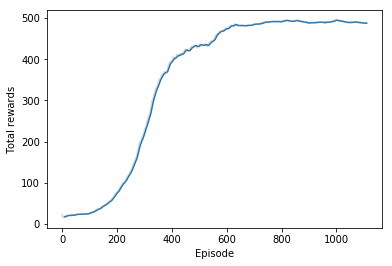

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

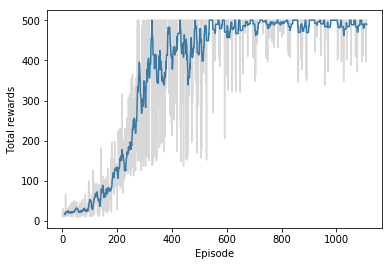

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [29]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

SyntaxError: invalid syntax (<ipython-input-29-a0b0af09d9f3>, line 6)

In [ ]:
eps, arr = np.array(dlossA_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

In [ ]:
eps, arr = np.array(dlossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.